In [1]:
import cv2 as cv
import math
import numpy as np
import sys
from random import random
from matplotlib import pyplot as plt

In [2]:
# Ядро Гаусса
def get_gauss_kernel(size, sigma) :
    sigma_const = 2*sigma*sigma
    kernel = np.zeros((size, size))
    half = (size // 2)
    for x in range(size) :
        for y in range(size) :
            step = -((x - half) * (x - half) + (y - half)) / sigma_const
            kernel[x][y] = 1 / (math.pi * sigma_const) * math.exp(step)
    
    normalization = np.sum(kernel)
    for i in range(size) :
        for j in range(size) :
            kernel[i][j] /= normalization
            
    return kernel

In [3]:
def add_padding(image, padding_size) :
    width, height, _ = image.shape
    new_image = np.zeros((width+2*padding_size, height+2*padding_size, 3), np.uint8)
    new_width, new_height, _ = new_image.shape    
    
    for i in range(width) :
        for j in range(height) :
            new_image[i+padding_size][j+padding_size] = image[i][j]
    for i in range(width) :
        for j in range(padding_size) :
            new_image[i+padding_size][j] = image[i][padding_size-j]
            new_image[i+padding_size][new_height -j -1] = image[i][height-padding_size+j-1]
    for i in range(padding_size) :
        for j in range(new_height) :
            new_image[i][j] = new_image[2*padding_size-i][j]
            new_image[new_width-i-1][j] = new_image[width+i-1][j]          
    return new_image

In [4]:
# умножения пикселя на ядро
def mult_kernel(image, i, j, kernel) :
    kernel_size, _ = kernel.shape
    half_kernel = kernel_size //2
    result = [0, 0, 0]
    start_img_i = i - half_kernel
    start_img_j = j - half_kernel
    
    for i in range(kernel_size) :
        for j in range(kernel_size) :
            result += (image[start_img_i + i][start_img_j + j] * kernel[i][j])
    return result
# проход ядром по картинке
def pass_kernel_through_image(image,kernel) :
    kernel_size, _ = kernel.shape
    half_kernel = kernel_size //2
    width, height, _ = image.shape
    new_width = width - half_kernel - half_kernel
    new_height = height - half_kernel - half_kernel
    image_result = image.copy()
    image_with_padding = add_padding(image, half_kernel)
    for i in range(new_width) :
        for j in range(new_height) :
            image_result[i][j] = mult_kernel(image_with_padding, i+half_kernel, j+half_kernel, kernel)
            
    return image_result

In [10]:
def gauss_blur(image,kernel_size,sigma):
    kernel = get_gauss_kernel(kernel_size, sigma)      
    result_image = pass_kernel_through_image(image, kernel)
    
    return result_image

In [13]:
def harris_detector(image, threshold):
    kernel_size = 3
    sigma = 1
    new_image = image.copy()    
    
    new_image = gauss_blur(image, kernel_size, sigma)
    dx = cv.Sobel(new_image,cv.CV_64F,1,0,ksize=3)
    dy = cv.Sobel(new_image,cv.CV_64F,0,1,ksize=3)
    
    # https://habr.com/ru/articles/244541/
    # f = det(H) / trace(H)
    # det(H) = A*C - B*B
    # trace(H) = A + C
    # r = det(H) - k*trace(H)*trace(H)
    # k - эмпирическая константа, [0.04, 0.06]
    k = 0.04
    
    Ixx = dx*dx
    Ixy = dx*dy
    Iyy = dy*dy
    
    h,w,_ = new_image.shape
    interesting_points = np.zeros((h,w))
    offset = 1
    x_range = h - offset
    y_range = w - offset
    
    for x in range(offset, x_range):
        for y in range(offset, y_range):
            start_x = x - offset
            end_x = x + offset + 1
            start_y = y - offset
            end_y = y + offset + 1            
            matrA = Ixx[start_x : end_x, start_y : end_y]
            matrB = Ixy[start_x : end_x, start_y : end_y]
            matrC = Iyy[start_x : end_x, start_y : end_y]
            A = matrA.sum()
            B = matrB.sum()
            C = matrC.sum()  
            
            r = ((A * C) - (B * B)) - (k * (A + C) * (A + C))            
            if r > 0:
                interesting_points[x, y] = r               
                
    cv.normalize(interesting_points, interesting_points, 0, 255, cv.NORM_MINMAX)
    for x in range(offset, x_range):
        for y in range(offset, y_range):
            if interesting_points[x, y] < threshold:
                interesting_points[x, y] = 0  
                
    print("points_count", len(np.nonzero(interesting_points)[0]))
    return interesting_points


In [14]:
def circle_interesting_points(image, interesting_points, radius):
    new_image = image.copy()
    h,w,_ = new_image.shape
    
    for x in range(0, h):
        for y in range(0, w):
            if interesting_points[x,y] > 0:
                cv.circle(new_image, (y, x), radius, (255,0,0), -1)                
    
    return new_image 

def color_interesting_points(image, interesting_points):
    new_image = image.copy()
    h,w,_ = new_image.shape
    
    for x in range(0, h):
        for y in range(0, w):
            if interesting_points[x,y] > 0:                
                new_image[x,y] = (255, 0, 0)
    
    return new_image

In [15]:
def nms(array, max_count):
    r=0
    h,w = array.shape
    while len(np.nonzero(array)[0]) > max_count:          
        r=r+1
        print("r =", r)
        for i in range(r, h-r, int(r*5)):
            for j in range(r, w-r, r+1):
                #print("i,j = ", i,j)
                #print(array)
                local_max = array[i,j]
                local_max_i = i
                local_max_j = j
                #print("local_max",local_max)
                for k in range(i-r, i+r+1):
                    for l in range(j-r, j+r+1):
                        #print("k,l =",k, l)
                        #print(array[k,l])
                        if array[k,l] >= local_max :
                            #print("new local min", array[k,l])
                            if (k == local_max_i) and (l == local_max_j):
                                continue
                            local_max = array[k,l]
                            array[local_max_i, local_max_j] = 0
                            local_max_i = k
                            local_max_j = l
                        else:
                            array[k,l] = 0
        print("points_count", len(np.nonzero(array)[0]))     
    return array   

points_count 48


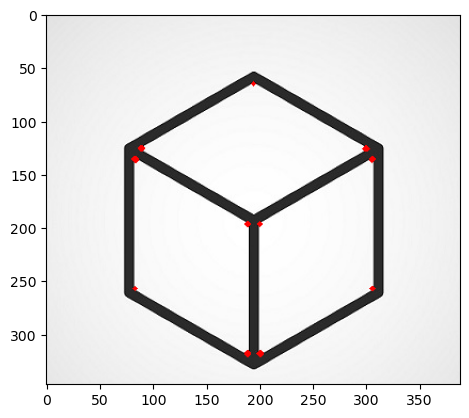

In [52]:
image = cv.imread('cube.png')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
points = harris_detector(image, 50)
points = nms(points, 200)
harris_image = circle_interesting_points(image, points, 2)
plt.imshow(harris_image) 

In [18]:
def get_chart_for_region(dx, dy, start_i, start_j) :
    region_size = 8
    end_i = start_i + 8
    end_j = start_j + 8
    chart = np.zeros(9)
    for i in range(start_i, end_i) :
        for j in range(start_j, end_j) :
            local_dx = dx[i][j]
            local_dy = dy[i][j]
            angle = np.arctan(local_dy / (local_dx + sys.float_info.epsilon)) * 180 / math.pi
            if (angle < 0) :
                angle += 180
            first_busket = int(angle // 20)
            second_busket = first_busket + 1
            if (second_busket > 8) :
                second_busket = 0
            value = math.sqrt(local_dx*local_dx + local_dy*local_dy)
            
            chart[first_busket] += abs((first_busket * 20 - angle) / 20 * value)
            chart[second_busket] += abs((second_busket * 20 - angle) / 20 * value)            
            
    return chart

# test
dx = np.zeros((16, 16))
for i in range(16):
    for j in range(16):
        dx[i][j] = (i * 16) + j + 1
        
dy = np.zeros((16, 16))
for i in range(16):
    for j in range(16):
        dy[i][j] = (i * 16) + j + 1
start_i = 3
start_j = 7
chart = get_chart_for_region(dx, dy, start_i, start_j)
print("Input:")
print("dx:\n", dx)
print("dy:\n", dy)
print("Start i:", start_i)
print("Start j:", start_j)
print("\nOutput:")
print("Chart:\n", chart)


Input:
dx:
 [[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
   15.  16.]
 [ 17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
   31.  32.]
 [ 33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
   47.  48.]
 [ 49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.
   63.  64.]
 [ 65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.
   79.  80.]
 [ 81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.
   95.  96.]
 [ 97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
  111. 112.]
 [113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
  127. 128.]
 [129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142.
  143. 144.]
 [145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158.
  159. 160.]
 [161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174.
  175. 176.]
 [177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 1

In [19]:
def flatten(array) :
    return [elem for sublist in array for elem in sublist]
def normalize_charts(charts) :
    coefficient = 0
    for i in range(len(charts)) :
        coefficient += charts[i] * charts[i]
    coefficient = math.sqrt(coefficient)
    for i in range(len(charts)) : 
        charts[i] /= coefficient
    return charts

def get_chart_for_point(dx, dy, i, j) :
    i_upper_regions = i - 7
    i_down_regions = i + 1
    j_left_regions = j - 7
    j_right_regions = j + 1
    
    charts = []
    charts.append(get_chart_for_region(dx, dy, i_upper_regions, j_left_regions))
    charts.append(get_chart_for_region(dx, dy, i_down_regions, j_left_regions))
    charts.append(get_chart_for_region(dx, dy, i_upper_regions, j_right_regions))
    charts.append(get_chart_for_region(dx, dy, i_down_regions, j_right_regions))    
    flatten_charts = flatten(charts)    
    
    return normalize_charts(flatten_charts) 

In [20]:
def get_charts_for_all_points(image, interesting_points) :
    sobel_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    dx = cv.Sobel(sobel_image, cv.CV_64F, 1, 0, ksize=3)
    dy = cv.Sobel(sobel_image, cv.CV_64F, 0, 1, ksize=3)
    all_charts = []
    h,w,_ = image.shape
    region_size = 8
    for i in range(region_size, h - region_size) :
        for j in range(region_size, w - region_size) :
            if interesting_points[i][j] > 0 :
                all_charts.append((j, i, get_chart_for_point(dx, dy, i, j)))
                
    return all_charts
    
    

In [22]:
# поскольку функция корня из x монотонно возрастает, то при сравнении
# расстояний между дескрипторами можно ее опустить
def get_l2distance_between_descriptors(chart1, chart2) :
    l2distance = 0
    for i in range(len(chart1)) :
        l2distance += ((chart1[i] - chart2[i]) ** 2)
        
    return l2distance

In [23]:
def get_all_nearby_descriptors(image1_charts, image2_charts, max_allowable_distance) :
    all_nearby = []
    image2_charts_copy = image2_charts.copy()
    for i in range(len(image1_charts)) :
        for j in range(len(image2_charts_copy)) :
            l2distance = get_l2distance_between_descriptors(image1_charts[i][2], image2_charts_copy[j][2])
            if (l2distance <= max_allowable_distance) :
                all_nearby.append((image1_charts[i][0],image1_charts[i][1],image2_charts_copy[j][0],image2_charts_copy[j][1]))
                image2_charts_copy.pop(j)
                j -= 1
                break
    return all_nearby

points_count 1543
r = 1
points_count 753
r = 2
points_count 457


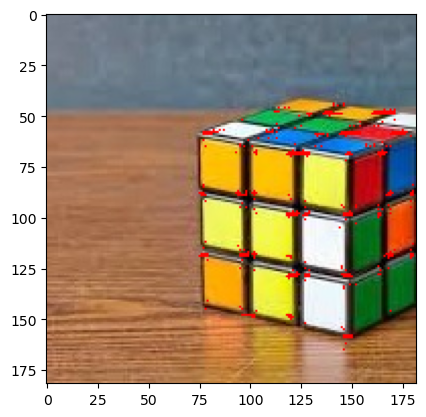

In [24]:
image1 = cv.imread('rubik_left.jpg')
image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
points1 = harris_detector(image1, 1)
points1 = nms(points1, 500)
harris_image1 = color_interesting_points(image1, points1)
plt.imshow(harris_image1) 
all_charts1 = get_charts_for_all_points(image1, points1)


points_count 1301
r = 1
points_count 688
r = 2
points_count 414


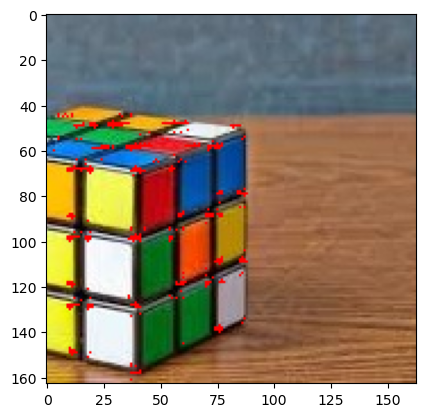

In [25]:
image2 = cv.imread('rubik_right.jpg')
image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
points2 = harris_detector(image2, 1)
points2 = nms(points2, 500)
harris_image2 = color_interesting_points(image2, points2)
plt.imshow(harris_image2) 
all_charts2 = get_charts_for_all_points(image2, points2)

In [26]:
all_nearby_points =  get_all_nearby_descriptors(all_charts1, all_charts2, 0.01)
print(len(all_nearby_points))

166


In [29]:
def color_nearby_points(image1, image2, nearby_points) :
    image1_copy = image1.copy()
    image2_copy = image2.copy()

    for i in range(len(nearby_points)) :        
        #color = (255, 0, 0) 
        color = [int(random() * 255), int(random() * 255), int(random() * 255)]
        cv.circle(image1_copy, (nearby_points[i][0], nearby_points[i][1]), 1, color, -1)
        cv.circle(image2_copy, (nearby_points[i][2], nearby_points[i][3]), 1, color, -1)

    return image1_copy, image2_copy

def circle_nearby_points(image1, image2, nearby_points, radius) :
    image1_copy = image1.copy()
    image2_copy = image2.copy()

    for i in range(len(nearby_points)) :        
        #color = (255, 0, 0)           
        color = [int(random() * 255), int(random() * 255), int(random() * 255)]
        cv.circle(image1_copy, (nearby_points[i][0], nearby_points[i][1]), radius, color, -1)
        cv.circle(image2_copy, (nearby_points[i][2], nearby_points[i][3]), radius, color, -1)

    return image1_copy, image2_copy

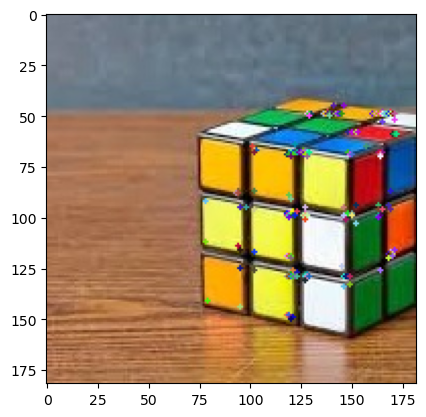

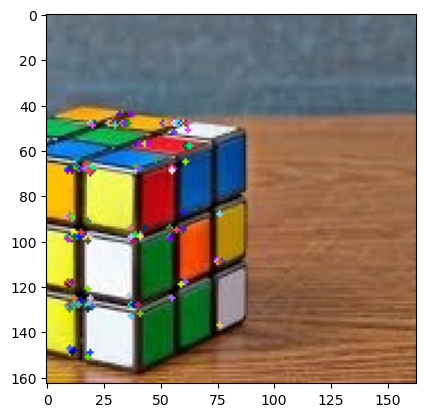

In [30]:
image1 = cv.imread('rubik_left.jpg')
image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
image2 = cv.imread('rubik_right.jpg')
image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
img1, img2 = color_nearby_points(image1, image2, all_nearby_points)
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

points_count 410


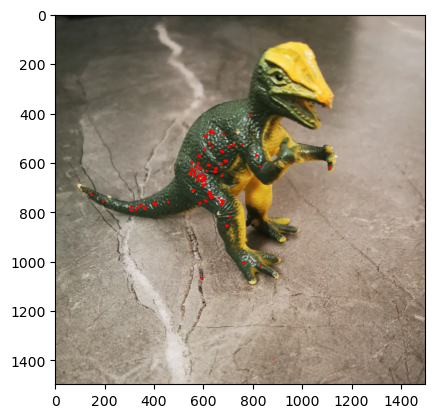

In [32]:
image1 = cv.imread('dino1.jpg')
image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
points1 = harris_detector(image1, 50)
#points1 = nms(points1, 500)
harris_image1 = circle_interesting_points(image1, points1, 5)
plt.imshow(harris_image1) 
all_charts1 = get_charts_for_all_points(image1, points1)


points_count 440


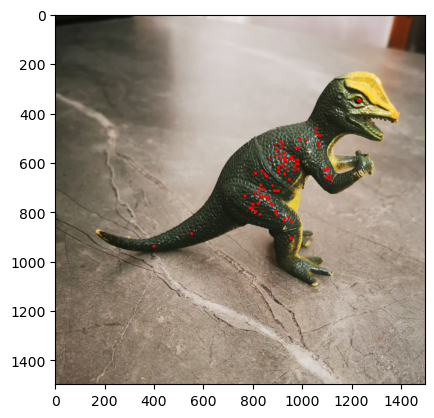

In [33]:
image2 = cv.imread('dino2.jpg')
image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
points2 = harris_detector(image2, 50)
points2 = nms(points2, 500)
harris_image2 = circle_interesting_points(image2, points2, 5)
plt.imshow(harris_image2) 
all_charts2 = get_charts_for_all_points(image2, points2)

In [34]:
all_nearby_points =  get_all_nearby_descriptors(all_charts1, all_charts2, 0.05)
print(len(all_nearby_points))

98


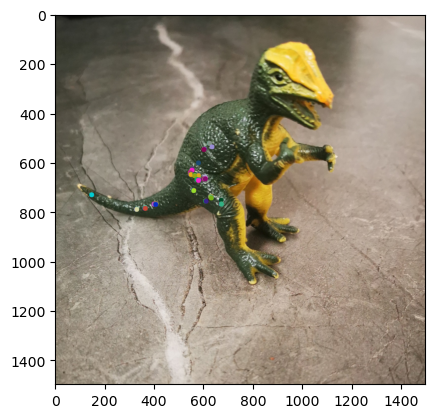

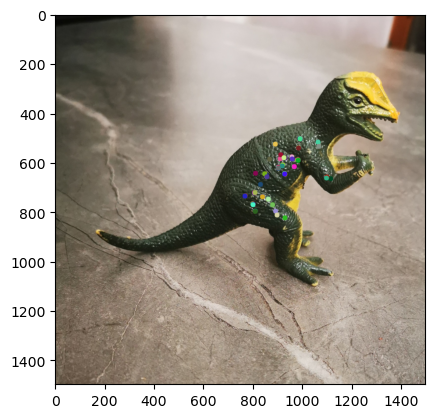

In [36]:
image1 = cv.imread('dino1.jpg')
image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
image2 = cv.imread('dino2.jpg')
image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
img1, img2 = circle_nearby_points(image1, image2, all_nearby_points, 10)
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

points_count 4355


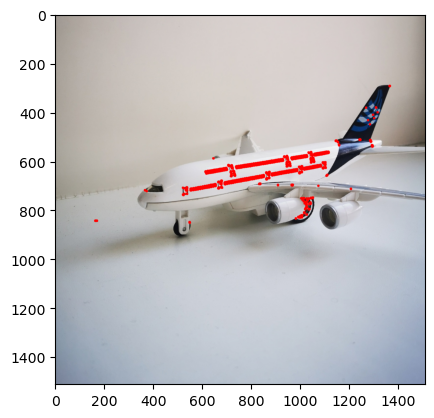

In [38]:
image1 = cv.imread('plane1.jpg')
image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
points1 = harris_detector(image1, 10)
#points1 = nms(points1, 500)
harris_image1 = circle_interesting_points(image1, points1, 5)
plt.imshow(harris_image1) 
all_charts1 = get_charts_for_all_points(image1, points1)


points_count 4786


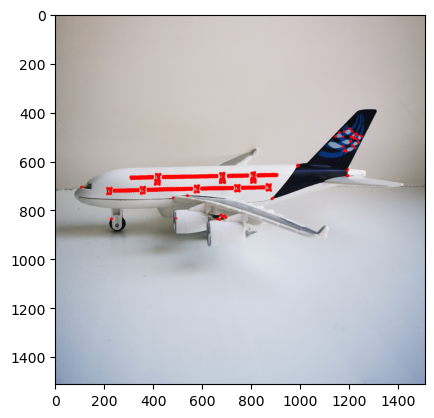

In [39]:
image2 = cv.imread('plane2.jpg')
image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
points2 = harris_detector(image2, 10)
#points2 = nms(points2, 500)
harris_image2 = circle_interesting_points(image2, points2, 5)
plt.imshow(harris_image2) 
all_charts2 = get_charts_for_all_points(image2, points2)

3651


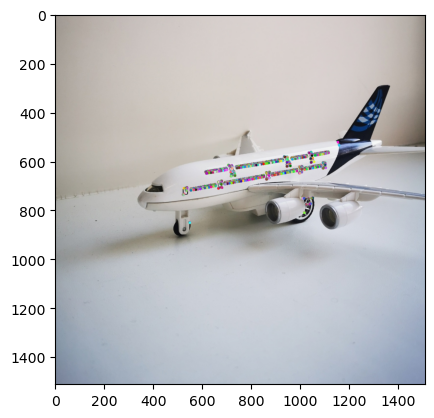

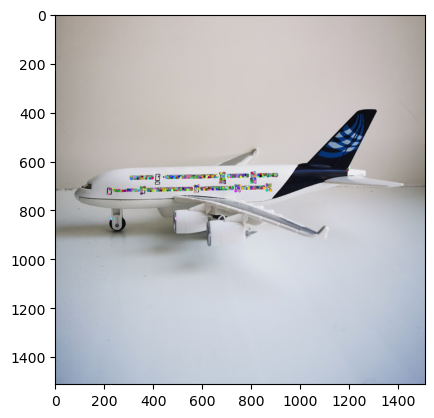

In [40]:
all_nearby_points =  get_all_nearby_descriptors(all_charts1, all_charts2, 0.05)
print(len(all_nearby_points))
image1 = cv.imread('plane1.jpg')
image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
image2 = cv.imread('plane2.jpg')
image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
img1, img2 = circle_nearby_points(image1, image2, all_nearby_points, 5)
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

points_count 1253


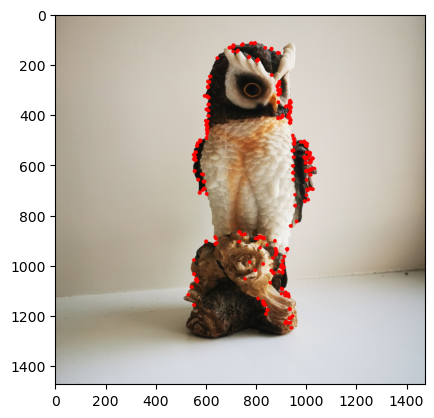

In [41]:
image1 = cv.imread('sova1.jpg')
image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
points1 = harris_detector(image1, 10)
#points1 = nms(points1, 500)
harris_image1 = circle_interesting_points(image1, points1, 7)
plt.imshow(harris_image1) 
all_charts1 = get_charts_for_all_points(image1, points1)


points_count 1565


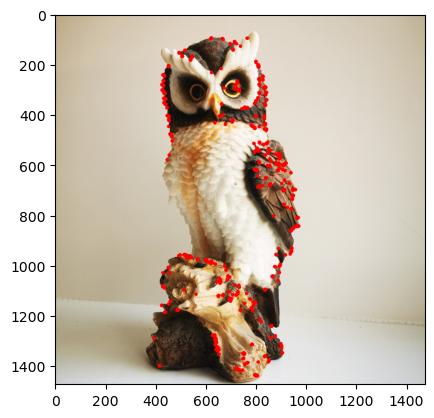

In [42]:
image2 = cv.imread('sova2.jpg')
image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
points2 = harris_detector(image2, 10)
#points2 = nms(points2, 500)
harris_image2 = circle_interesting_points(image2, points2, 7)
plt.imshow(harris_image2) 
all_charts2 = get_charts_for_all_points(image2, points2)

551


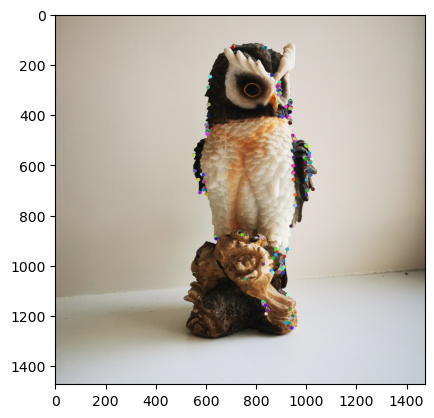

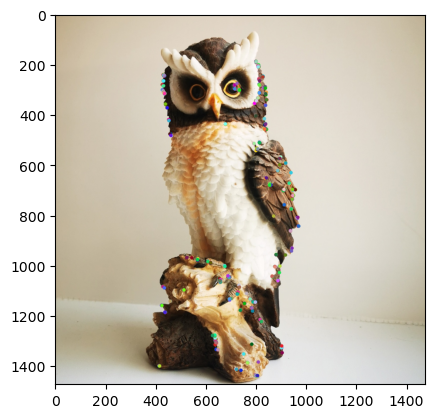

In [43]:
all_nearby_points =  get_all_nearby_descriptors(all_charts1, all_charts2, 0.05)
print(len(all_nearby_points))
image1 = cv.imread('sova1.jpg')
image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
image2 = cv.imread('sova2.jpg')
image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
img1, img2 = circle_nearby_points(image1, image2, all_nearby_points, 7)
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

points_count 791


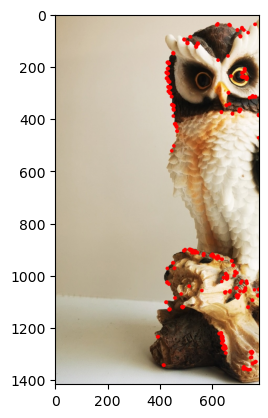

In [44]:
image1 = cv.imread('sova5.jpg')
image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
points1 = harris_detector(image1, 10)
#points1 = nms(points1, 500)
harris_image1 = circle_interesting_points(image1, points1, 7)
plt.imshow(harris_image1) 
all_charts1 = get_charts_for_all_points(image1, points1)

points_count 1949


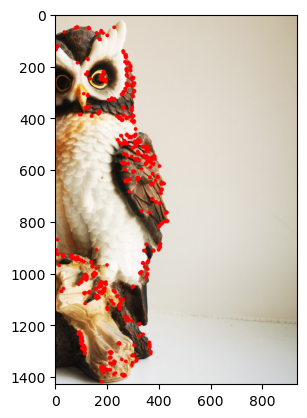

In [45]:
image2 = cv.imread('sova6.jpg')
image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
points2 = harris_detector(image2, 10)
#points2 = nms(points2, 500)
harris_image2 = circle_interesting_points(image2, points2, 7)
plt.imshow(harris_image2) 
all_charts2 = get_charts_for_all_points(image2, points2)

544


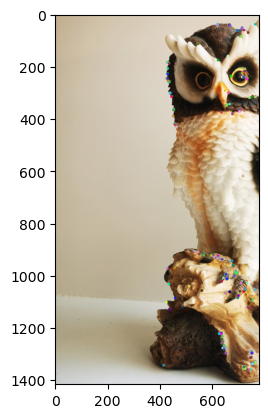

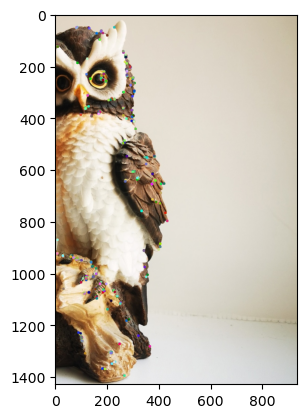

In [46]:
all_nearby_points =  get_all_nearby_descriptors(all_charts1, all_charts2, 0.05)
print(len(all_nearby_points))
image1 = cv.imread('sova5.jpg')
image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
image2 = cv.imread('sova6.jpg')
image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
img1, img2 = circle_nearby_points(image1, image2, all_nearby_points, 5)
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

points_count 791
r = 1
points_count 457
r = 2
points_count 331
r = 3
points_count 261
r = 4
points_count 216
r = 5
points_count 175


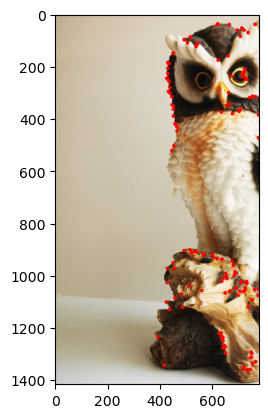

In [47]:
image1 = cv.imread('sova5.jpg')
image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
points1 = harris_detector(image1, 10)
points1 = nms(points1, 200)
harris_image1 = circle_interesting_points(image1, points1, 7)
plt.imshow(harris_image1) 
all_charts1 = get_charts_for_all_points(image1, points1)

points_count 1949
r = 1
points_count 1180
r = 2
points_count 811
r = 3
points_count 618
r = 4
points_count 540
r = 5
points_count 427
r = 6
points_count 313
r = 7
points_count 271
r = 8
points_count 241
r = 9
points_count 212
r = 10
points_count 189


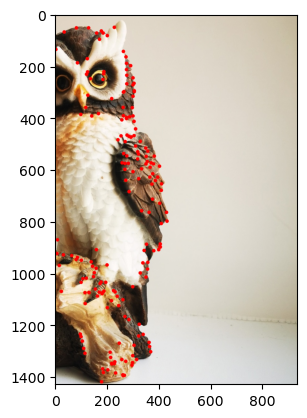

In [48]:
image2 = cv.imread('sova6.jpg')
image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
points2 = harris_detector(image2, 10)
points2 = nms(points2, 200)
harris_image2 = circle_interesting_points(image2, points2, 7)
plt.imshow(harris_image2) 
all_charts2 = get_charts_for_all_points(image2, points2)

13


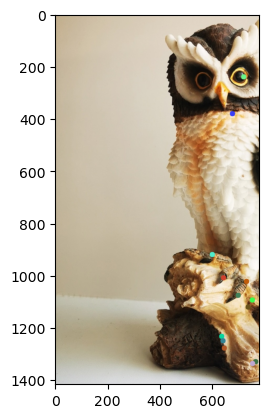

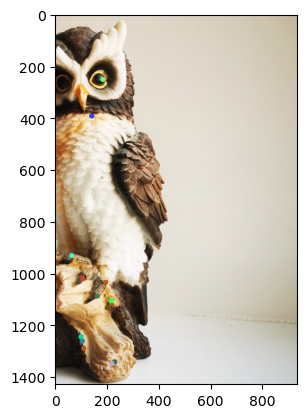

In [49]:
all_nearby_points =  get_all_nearby_descriptors(all_charts1, all_charts2, 0.005)
print(len(all_nearby_points))
image1 = cv.imread('sova5.jpg')
image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
image2 = cv.imread('sova6.jpg')
image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
img1, img2 = circle_nearby_points(image1, image2, all_nearby_points, 10)
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

5


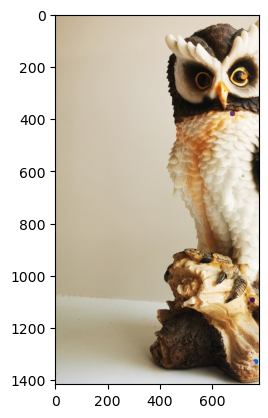

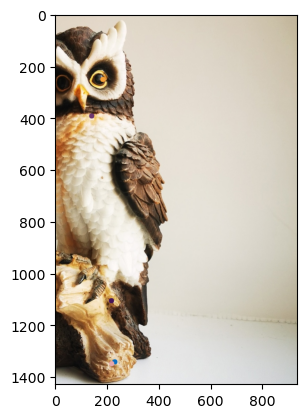

In [50]:
all_nearby_points =  get_all_nearby_descriptors(all_charts1, all_charts2, 0.002)
print(len(all_nearby_points))
image1 = cv.imread('sova5.jpg')
image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
image2 = cv.imread('sova6.jpg')
image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
img1, img2 = circle_nearby_points(image1, image2, all_nearby_points, 10)
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()